# Customer Purchase Prediction

## Data Definition:
The dataset stores some of the information of a customer's visit on the e-commerce website.

- **productstatus**: Product Status
            - View
            - Cart
            - Purchase
- **brand**: Brand associated with the product
- **price**: Price of the product (in INR)
- **product_category**: Category of the product
- **product**: Type of product
- **clicktime**: Date and time of user accessing the website
- **uid**: Customer's Unique
- **pid**: Unique Product Identification Number
- **categorycode**: Category code of the product

Read the given data and answer the following question to predict whether a product will be purchased by a customer or not

### Q. Read the data and print total number of observations and total number of columns

In [1]:
# save file location and type
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
from pyspark.sql.functions import isnull, when, count, col,avg
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
 
sc = SparkContext.getOrCreate()
spark = SparkSession(sc) 
file_location = "pluskart.csv"
file_type = "csv"

# CSV options
infer_schema = True
first_row_is_header = True
delimiter = ","

# the applied options are for CSV files. For other file types, these will be ignored.
rawDF = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .load(file_location)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/08/07 19:35:01 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/08/07 19:35:03 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
22/08/07 19:35:03 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
22/08/07 19:35:03 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.
22/08/07 19:35:03 WARN Utils: Service 'SparkUI' could not bind on port 4043. Attempting port 4044.
22/08/07 19:35:03 WARN Utils: Service 'SparkUI' could not bind on port 4044. Attempting port 4045.
22/08/07 19:35:03 WARN Utils: Service 'SparkUI' could not bind on port 4045. Attempting port 4046.
22/08/07 19:35:03 WARN Utils: Service 'SparkUI' could not bind on port 4046. Attempting port 4047.
22/08/07 19:35:03 WARN Utils: Service 'SparkUI' could not bind on port 4047. Attempting port 4048.
22/08/07 19:35:03 WARN Utils: Service 'SparkUI' could not bind on

In [2]:
# check if the dataset is read as rawDF
rawDF.show(5, False)

22/08/07 19:35:34 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , productstatus, brand, price, product_category, product, clicktime, uid, pid, categorycode
 Schema: _c0, productstatus, brand, price, product_category, product, clicktime, uid, pid, categorycode
Expected: _c0 but found: 
CSV file: file:///Users/kaustuvkunal/Downloads/Session%206_PySparkML/Take%20Home%20Exercise/pluskart.csv
+---+-------------+--------+------------------+----------------+----------+-------------------+--------+------+------------------+
|_c0|productstatus|brand   |price             |product_category|product   |clicktime          |uid     |pid   |categorycode      |
+---+-------------+--------+------------------+----------------+----------+-------------------+--------+------+------------------+
|0  |view         |pandora |16300.079999999998|auto            |alarm     |2021-05-30 11:37:41|74574724|857172|293287651543950584|
|1  |view         |moulinex|5001.84           |null     

In [3]:
# number of rows and columns in the dataset
print("Number of Rows: ", rawDF.count())
print("Number of Columns: ",len(rawDF.columns))

Number of Rows:  12734629
Number of Columns:  10


There are more than 12 million records in the dataset with 10 columns

#### Q. Treat missing values and remove unnecessary columns

In [4]:
from pyspark.sql.functions import isnull, when, count, col
# count the number of missing values for each column
rawDF.select([count(when(isnull(c), c)).alias(c) for c in rawDF.columns]).show()

22/08/07 19:35:39 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , productstatus, brand, price, product_category, product, clicktime, uid, pid, categorycode
 Schema: _c0, productstatus, brand, price, product_category, product, clicktime, uid, pid, categorycode
Expected: _c0 but found: 
CSV file: file:///Users/kaustuvkunal/Downloads/Session%206_PySparkML/Take%20Home%20Exercise/pluskart.csv


+---+-------------+-------+-----+----------------+-------+---------+---+---+------------+
|_c0|productstatus|  brand|price|product_category|product|clicktime|uid|pid|categorycode|
+---+-------------+-------+-----+----------------+-------+---------+---+---+------------+
|  0|            0|1835694|    0|         4054470|4054470|        0|  0|  0|           0|
+---+-------------+-------+-----+----------------+-------+---------+---+---+------------+



In [5]:
# Use df_name.na.drop() to drop all the null values from the dataframe
rawDF = rawDF.na.drop()

In [6]:
rawDF.select([count(when(isnull(c), c)).alias(c) for c in rawDF.columns]).show()

22/08/07 19:35:58 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , productstatus, brand, price, product_category, product, clicktime, uid, pid, categorycode
 Schema: _c0, productstatus, brand, price, product_category, product, clicktime, uid, pid, categorycode
Expected: _c0 but found: 
CSV file: file:///Users/kaustuvkunal/Downloads/Session%206_PySparkML/Take%20Home%20Exercise/pluskart.csv


+---+-------------+-----+-----+----------------+-------+---------+---+---+------------+
|_c0|productstatus|brand|price|product_category|product|clicktime|uid|pid|categorycode|
+---+-------------+-----+-----+----------------+-------+---------+---+---+------------+
|  0|            0|    0|    0|               0|      0|        0|  0|  0|           0|
+---+-------------+-----+-----+----------------+-------+---------+---+---+------------+



from the above results we can see that the dataframe does not contain any missing value

In [7]:
# number of rows and columns in the dataset
print("Number of Rows: ", rawDF.count())
print("Number of Columns: ",len(rawDF.columns))

22/08/07 19:36:15 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , productstatus, brand, price, product_category, product, clicktime, uid, pid, categorycode
 Schema: _c0, productstatus, brand, price, product_category, product, clicktime, uid, pid, categorycode
Expected: _c0 but found: 
CSV file: file:///Users/kaustuvkunal/Downloads/Session%206_PySparkML/Take%20Home%20Exercise/pluskart.csv


Number of Rows:  7967322
Number of Columns:  10


After dropping all the missing values we now have almost 8 million records with 10 columns

We now drop the column '_c0' as it is not required for our analysis

In [8]:
# use the drop() transformer to drop the selected column "_c0"
rawDF = rawDF.drop('_c0')

In [9]:
# check if the column has been dropped
rawDF.show(5, False)

22/08/07 19:36:31 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , productstatus, brand, price, product_category, product, clicktime, uid, pid, categorycode
 Schema: _c0, productstatus, brand, price, product_category, product, clicktime, uid, pid, categorycode
Expected: _c0 but found: 
CSV file: file:///Users/kaustuvkunal/Downloads/Session%206_PySparkML/Take%20Home%20Exercise/pluskart.csv
+-------------+-------+------------------+----------------+----------+-------------------+--------+------+------------------+
|productstatus|brand  |price             |product_category|product   |clicktime          |uid     |pid   |categorycode      |
+-------------+-------+------------------+----------------+----------+-------------------+--------+------+------------------+
|view         |pandora|16300.079999999998|auto            |alarm     |2021-05-30 11:37:41|74574724|857172|293287651543950584|
|cart         |philips|22237.92          |appliances      |vacuum    |2021-0

In [10]:
# we will cache the dataset at this stage since the dataset is huge
kartDF = rawDF.cache()

#### Q. Check column data types and change the column data type if required

In [11]:
# check the data types of the columns
kartDF.printSchema()

root
 |-- productstatus: string (nullable = true)
 |-- brand: string (nullable = true)
 |-- price: double (nullable = true)
 |-- product_category: string (nullable = true)
 |-- product: string (nullable = true)
 |-- clicktime: timestamp (nullable = true)
 |-- uid: integer (nullable = true)
 |-- pid: integer (nullable = true)
 |-- categorycode: long (nullable = true)



In [12]:
# change the type of column clicktime to timestamp and drop it 
from pyspark.sql.functions import to_timestamp
kartDF = kartDF.withColumn('clickeventtime', to_timestamp('clicktime', 'yyyy-MM-dd HH:mm:ss')).drop("clicktime")

In [13]:
kartDF.show(5)

22/08/07 19:36:31 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , productstatus, brand, price, product_category, product, clicktime, uid, pid, categorycode
 Schema: _c0, productstatus, brand, price, product_category, product, clicktime, uid, pid, categorycode
Expected: _c0 but found: 
CSV file: file:///Users/kaustuvkunal/Downloads/Session%206_PySparkML/Take%20Home%20Exercise/pluskart.csv


+-------------+-------+------------------+----------------+----------+--------+------+------------------+-------------------+
|productstatus|  brand|             price|product_category|   product|     uid|   pid|      categorycode|     clickeventtime|
+-------------+-------+------------------+----------------+----------+--------+------+------------------+-------------------+
|         view|pandora|16300.079999999998|            auto|     alarm|74574724|857172|293287651543950584|2021-05-30 11:37:41|
|         cart|philips|          22237.92|      appliances|    vacuum|75325121|528715|293287652283346502|2021-05-04 09:52:54|
|         view|oneplus|          15363.36|     electronics|smartphone|75910037|143594|293287650804554665|2021-05-28 14:29:19|
|         view|  vitek|           1869.84|      appliances|      iron|73346332|542961|293287652310909073|2021-05-05 08:36:51|
|         view|  apple|          67088.88|     electronics|smartphone|75456781|143330|293287650804554665|2021-05-11 17

In [14]:
kartDF.printSchema()

root
 |-- productstatus: string (nullable = true)
 |-- brand: string (nullable = true)
 |-- price: double (nullable = true)
 |-- product_category: string (nullable = true)
 |-- product: string (nullable = true)
 |-- uid: integer (nullable = true)
 |-- pid: integer (nullable = true)
 |-- categorycode: long (nullable = true)
 |-- clickeventtime: timestamp (nullable = true)



We can see that the "clickeventtime" is of type 'timestamp'

### Exploratory Data Analysis

#### Q. Find the top 10 products that the company sold in the month of May

In [15]:
# most popular products sold
kartDF.select('product').groupBy('product').count().orderBy('count', ascending = False).show(10)

+-------------+-------+
|      product|  count|
+-------------+-------+
|   smartphone|3444673|
|       clocks| 339168|
|     notebook| 338629|
|           tv| 334202|
|    headphone| 327452|
|       washer| 257943|
|       vacuum| 233632|
|refrigerators| 213575|
|        shoes| 181373|
|      desktop| 121287|
+-------------+-------+
only showing top 10 rows



From the above result, we can observe that Smartphones and other electronic products are ordered a lot from this ecommerce website. Lets confirm this by list the most popular product category.

In [16]:
# most popular product categories
kartDF.select('product_category').groupBy('product_category').count().orderBy('count', ascending = False).show(10)

+----------------+-------+
|product_category|  count|
+----------------+-------+
|     electronics|4750428|
|      appliances|1398255|
|       computers| 675376|
|         apparel| 340107|
|            auto| 230090|
|    construction| 164909|
|       furniture| 162142|
|            kids| 127557|
|     accessories|  62480|
|           sport|  45975|
+----------------+-------+
only showing top 10 rows



From the above result, we can confirm that electronic items are most ordered product category

#### Q.List down five least sold products that the company sold in the month of May

In [17]:
# least popular products sold
kartDF.select('product').groupBy('product').count().orderBy('count', ascending = True).show(5)

+-----------+-----+
|    product|count|
+-----------+-----+
|      bench|   65|
|  soldering|   67|
|anti_freeze|   89|
|       belt|  112|
|     shorts|  136|
+-----------+-----+
only showing top 5 rows



#### Q. List down the most popular brand

In [18]:
# most popular brands
kartDF.select('brand').groupBy('brand').count().orderBy('count', ascending = False).show(10)

+-------+-------+
|  brand|  count|
+-------+-------+
|samsung|1548147|
|  apple|1227764|
|oneplus| 827165|
| lenovo| 429497|
|     lg| 152919|
|   oppo| 144716|
|   acer| 128539|
|  bosch|  99201|
|     hp|  88548|
|indesit|  86810|
+-------+-------+
only showing top 10 rows



We can see that Samsung, Apple, OnePlus are some of the highest ordered smartphones

#### Q. What is the average amount spend on smartphones

In [19]:
# average amount spent on smartphones by the customers
kartDF.select('price').filter("product == 'smartphone'").describe().show()

+-------+------------------+
|summary|             price|
+-------+------------------+
|  count|           3444673|
|   mean|34000.587350681766|
| stddev|29023.131712024166|
|    min|            1000.8|
|    max|          151952.4|
+-------+------------------+



The average amount spent by a customer on smartphone is nearly 34000 INR

#### Q. Find the user's website activities on each day of the week and plot bar chart showing the number of user activities on each day of the week

In [20]:
neDF = kartDF

In [21]:
from pyspark.sql.functions import date_format
kartDF=neDF.withColumn('dayofweek', date_format('clickeventtime', 'E'))

In [22]:
kartDF.show(5)

+-------------+-------+------------------+----------------+----------+--------+------+------------------+-------------------+---------+
|productstatus|  brand|             price|product_category|   product|     uid|   pid|      categorycode|     clickeventtime|dayofweek|
+-------------+-------+------------------+----------------+----------+--------+------+------------------+-------------------+---------+
|         view|pandora|16300.079999999998|            auto|     alarm|74574724|857172|293287651543950584|2021-05-30 11:37:41|      Sun|
|         cart|philips|          22237.92|      appliances|    vacuum|75325121|528715|293287652283346502|2021-05-04 09:52:54|      Tue|
|         view|oneplus|          15363.36|     electronics|smartphone|75910037|143594|293287650804554665|2021-05-28 14:29:19|      Fri|
|         view|  vitek|           1869.84|      appliances|      iron|73346332|542961|293287652310909073|2021-05-05 08:36:51|      Wed|
|         view|  apple|          67088.88|     e

In [23]:
actDF = kartDF.select("dayofweek").groupBy("dayofweek").count().orderBy("dayofweek").toPandas()

In [24]:
actDF.head(7)

,dayofweek,count
0,Fri,1000972
1,Mon,1206509
2,Sat,1262487
3,Sun,1243631
4,Thu,1101009
5,Tue,1095500
6,Wed,1057214


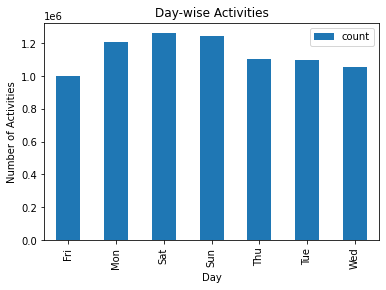

In [25]:
# create the plot
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,10)
actDF.plot(x = 'dayofweek', kind='bar')
plt.title('Day-wise Activities')
plt.ylabel('Number of Activities')
plt.xlabel('Day')
plt.show()

From the above plot, we can observe that there is a peak on Saturday, Sunday and Monday. We can say that most of the activities on website takes place on weekends

In [26]:
kartDF.show(5)

+-------------+-------+------------------+----------------+----------+--------+------+------------------+-------------------+---------+
|productstatus|  brand|             price|product_category|   product|     uid|   pid|      categorycode|     clickeventtime|dayofweek|
+-------------+-------+------------------+----------------+----------+--------+------+------------------+-------------------+---------+
|         view|pandora|16300.079999999998|            auto|     alarm|74574724|857172|293287651543950584|2021-05-30 11:37:41|      Sun|
|         cart|philips|          22237.92|      appliances|    vacuum|75325121|528715|293287652283346502|2021-05-04 09:52:54|      Tue|
|         view|oneplus|          15363.36|     electronics|smartphone|75910037|143594|293287650804554665|2021-05-28 14:29:19|      Fri|
|         view|  vitek|           1869.84|      appliances|      iron|73346332|542961|293287652310909073|2021-05-05 08:36:51|      Wed|
|         view|  apple|          67088.88|     e

#### Preparing data for model building

In [27]:
import pyspark.sql.functions as f
df = kartDF.withColumn('label', f.when(kartDF['productstatus']=='purchase',1).otherwise(0))

In [28]:
# Printing the count of each label
df.groupBy('label').count().show()

+-----+-------+
|label|  count|
+-----+-------+
|    1| 165012|
|    0|7802310|
+-----+-------+



#### Q. Divide the data in train and test set

In [29]:
# We spilt the data into 70-30 set
# Training Set - 70% obesevations
# Testing Set - 30% observations
trainDF, testDF =  df.randomSplit([0.7,0.3], seed = 2020)

# print the count of observations in each set
print("Observations in training set = ", trainDF.count())
print("Observations in testing set = ", testDF.count())

Observations in training set =  5577362


Observations in testing set =  2389960


#### Q. Apply necessary transformation required to preapre data for machine learning

In [30]:
# Categorising the attributes into its type
cat_features=['brand','product_category', 'product', 'dayofweek']
cont_features=['price']

In [31]:
# importing all the required libraries for feature transformation
from pyspark.ml.feature import OneHotEncoder,StringIndexer,VectorAssembler

# defining an empty list to hold transforming stages
# to prepare pipelines
stages=[]


# Encoding categorical features
for catcol in cat_features:
    indexer=StringIndexer(inputCol=catcol,outputCol=catcol+'_index').setHandleInvalid("keep")
    encoder=OneHotEncoder(inputCols=[indexer.getOutputCol()],outputCols=[catcol+"_enc"])
    stages+=[indexer,encoder]

In [32]:
assemblerInputs=[col+"_enc" for col in cat_features]+cont_features
assembler=VectorAssembler(inputCols=assemblerInputs,outputCol="features")
stages+=[assembler]

In [33]:
# Scaling the features vector
from pyspark.ml.feature import MinMaxScaler
scaler = MinMaxScaler().setInputCol("features").setOutputCol("scaled_features")
stages+=[scaler]

### Building pipeline model
We will build multiple models to predict if the product is purchased or just viewed. We start with Logistic Regression model

#### Q. Build a logistic regression pipeline model

In [34]:
# Importing the library for Logistic regression
from pyspark.ml.classification import LogisticRegression

# create the logistic model and store this estimator in pipeline stages 
lr = LogisticRegression(featuresCol='scaled_features', labelCol='label')

stages += [lr] 

In [ ]:
# Building a spark ml pipeline to transform the data
from pyspark.ml import Pipeline
pipeline = Pipeline(stages=stages)

# Fit the pipeline to training documents.
model = pipeline.fit(trainDF)

In [ ]:
# Make predictions on test documents and print columns of interest.
predictionDF = model.transform(testDF)

In [ ]:
predictionDF.select("rawPrediction", "probability", "prediction", "label").show(10,False)

#### Q. Evaluate the logistic regression pipeline model

In [ ]:
# import BinaryClassificationEvaluator from the pyspark.ml.evaluation package
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Build the BinaryClassificationEvaluator object 'evaluator'
evaluator = BinaryClassificationEvaluator()

# Calculate the accracy and print its value
accuracy = predictionDF.filter(predictionDF.label == predictionDF.prediction).count()/float(predictionDF.count())
print("Accuracy = ", accuracy)

# evaluate(predictiondataframe) gets area under the ROC curve
print('Area under the ROC curve = ', evaluator.evaluate(predictionDF))

Or you can also try....

In [ ]:
# import MulticlassClassificationEvaluator from the pyspark.ml.evaluation package
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Build the MulticlassClassificationEvaluator object 'evaluator'
multievaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")

# 1. Accuracy
print("Accuracy: ", multievaluator.evaluate(predictionDF, {evaluator.metricName: "accuracy"})) 
# 2. Area under the ROC curve
print('Area under the ROC curve = ', evaluator.evaluate(predictionDF))
# 3. Precision (Positive Predictive Value)
print("Precision = ", multievaluator.evaluate(predictionDF, {evaluator.metricName: "weightedPrecision"}))
# 4. Recall (True Positive Rate)
print("Recall = ", multievaluator.evaluate(predictionDF, {evaluator.metricName: "weightedRecall"}))
# 5. F1 Score (F-measure)
print("F1 Score = ", multievaluator.evaluate(predictionDF, {evaluator.metricName: "f1"}))

#### Q. Build a decision tree pipeline model

In [ ]:
# Importing the library for Decision Tree
from pyspark.ml.classification import DecisionTreeClassifier

# create the logistic model and store this estimator in pipeline stages 
dt = DecisionTreeClassifier(featuresCol="features", labelCol="label")

In [ ]:
dtstages = []
for catcol in cat_features:
    indexer=StringIndexer(inputCol=catcol,outputCol=catcol+'_index').setHandleInvalid("keep")
    encoder=OneHotEncoder(inputCols=[indexer.getOutputCol()],outputCols=[catcol+"_enc"])
    dtstages+=[indexer,encoder]

In [ ]:
dtstages+=[assembler, dt]

In [ ]:
dtstages

In [ ]:
dtpipeline = Pipeline(stages=dtstages)

# Fit the pipeline to training documents.
dtmodel = dtpipeline.fit(trainDF)

In [ ]:
# Make predictions on test documents and print columns of interest.
dtpredictionDF = dtmodel.transform(testDF)

#### Q. Evaluate the decision tree pipeline model

In [ ]:
# 1. Accuracy
print("Accuracy: ", multievaluator.evaluate(dtpredictionDF, {evaluator.metricName: "accuracy"})) 
# 2. Area under the ROC curve
print('Area under the ROC curve = ', evaluator.evaluate(dtpredictionDF))
# 3. Precision (Positive Predictive Value)
print("Precision = ", multievaluator.evaluate(dtpredictionDF, {evaluator.metricName: "weightedPrecision"}))
# 4. Recall (True Positive Rate)
print("Recall = ", multievaluator.evaluate(dtpredictionDF, {evaluator.metricName: "weightedRecall"}))
# 5. F1 Score (F-measure)
print("F1 Score = ", multievaluator.evaluate(dtpredictionDF, {evaluator.metricName: "f1"}))

Conclusion:
From the above output we can conclude that the logistic regression model has a better performance in prediciting whether the customer will purchase the product or not